In [36]:
from copy import deepcopy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.cross_decomposition import PLSRegression, PLSCanonical

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold



In [3]:
samples = pd.read_excel(u'20.01.23 список образцов Моча.xlsx', header=2)
samples.dropna(subset=['Gender'], inplace=True)

samples.fillna(0, inplace=True)
samples.reset_index(drop=True, inplace=True)

In [4]:
spectra1 = pd.read_csv('urine_chm001-250.csv')
spectra2 = pd.read_csv('urine_chm251-500.csv')
spectra_init = pd.concat([spectra1, spectra2],  ignore_index=True)

spectra = spectra_init.filter(regex='^Ch')

mmscaler = MinMaxScaler()
spectra = pd.DataFrame(mmscaler.fit_transform(spectra.T).T)

In [5]:
frame_lol = samples[['Dataset', 'TOTAL_a']]

spectra['Dataset'] = spectra_init['Dataset']
spectra = pd.merge(left=spectra, right=frame_lol, how='left', on='Dataset')
spectra.dropna(subset=['TOTAL_a'], inplace=True)

Pacients_data = spectra[['Dataset', 'TOTAL_a']].drop_duplicates()

In [ ]:
PLSRegression.predict()

In [49]:
def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)).round(3)
    mae = mean_absolute_error(y_true, y_pred).round(3)
    r2 = r2_score(y_true, y_pred).round(3)
    return [rmse, mae, r2]

In [39]:
from itertools import chain

In [82]:
Metrics = []

gkf = GroupKFold(n_splits=10)

X = spectra.drop(['Dataset', 'TOTAL_a'], axis=1)
y = spectra.TOTAL_a
groups = spectra.Dataset

true_to_plot, preds_to_plot = [], []

for train_indicies, test_indicies in gkf.split(X, y, groups):
    Train_X, Test_X = X.iloc[train_indicies,:], X.iloc[test_indicies,:]
    Train_y, Test_y = y.iloc[train_indicies], y.iloc[test_indicies]
    
    PLS  = PLSRegression(n_components=7).fit(Train_X, Train_y)
    Preds = PLS.predict(Test_X)
    
    true_to_plot.append(Test_y)
    preds_to_plot.append(Preds)
    
    Metrics.append(get_metrics(Test_y, Preds))
true_to_plot = list(chain(*true_to_plot))
preds_to_plot = list(chain(*preds_to_plot))

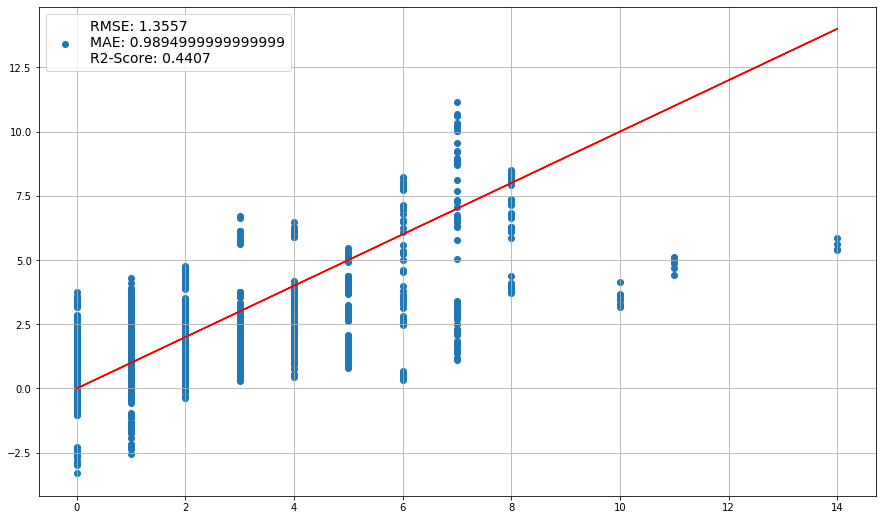

In [83]:
Label = 'RMSE: {}\nMAE: {}\nR2-Score: {}'.format(*np.mean(Metrics, axis=0))

plt.figure(figsize=(15,9))
plt.scatter(true_to_plot, preds_to_plot, label=Label)
plt.plot(true_to_plot, true_to_plot, c='r')
plt.grid()
plt.legend(fontsize=14)